## 1. Getting Started

[Doc: getting started](https://robomimic.github.io/docs/introduction/getting_started.html)
To use tensorboard, run
```bash
tensorboard --logdir bc_trained_models/test --host 127.0.0.1 --port 6006
```

### 1.1. Off-screen renderer test

[robosuite INFO] Loading controller configuration from: /home1/kwang570/.conda/envs/latent_sope/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:121)
[robosuite INFO] Loading controller configuration from: /home1/kwang570/.conda/envs/latent_sope/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:121)


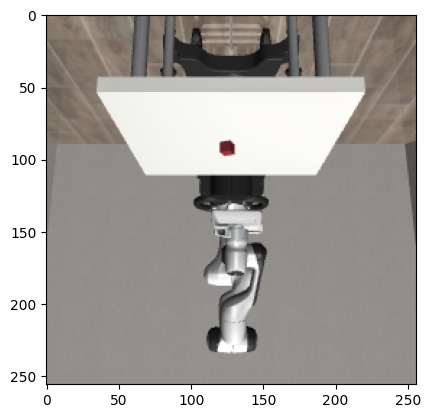

[robosuite INFO] Loading controller configuration from: /home1/kwang570/.conda/envs/latent_sope/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:121)
INFO:robosuite_logs:Loading controller configuration from: /home1/kwang570/.conda/envs/latent_sope/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json


	frame dtype/shape: uint8 (256, 256, 3)
	frame min/max: 6 255
	✅ robosuite render OK

============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: []
using obs modality: rgb with keys: []
using obs modality: depth with keys: []
using obs modality: scan with keys: []


[robosuite INFO] Loading controller configuration from: /home1/kwang570/.conda/envs/latent_sope/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:121)
INFO:robosuite_logs:Loading controller configuration from: /home1/kwang570/.conda/envs/latent_sope/lib/python3.10/site-packages/robosuite/controllers/config/robots/default_panda.json


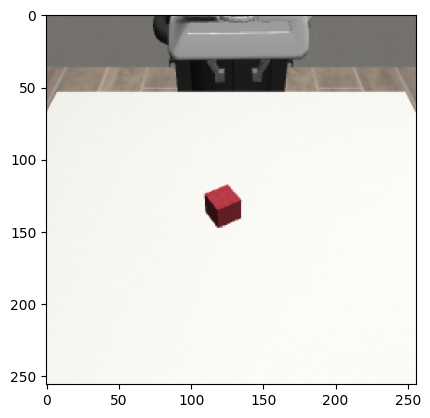

	robomimic rgb_array: <class 'numpy.ndarray'> (256, 256, 3) uint8
	✅ robomimic render OK


In [2]:
# Off-screen renderer test
import os
import numpy as np
import matplotlib.pyplot as plt
import robosuite as suite
from robomimic.envs.env_robosuite import EnvRobosuite
import robomimic.utils.obs_utils as ObsUtils

os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.environ["MUJOCO_EGL_DEVICE_ID"] = os.environ.get("MUJOCO_EGL_DEVICE_ID", "0")

def test_robosuite_offscreen_render():
    env = suite.make(
        env_name="Lift",
        robots="Panda",
        has_renderer=False,              # no onscreen window
        has_offscreen_renderer=True,     # we want rgb_array frames
        use_camera_obs=False,
        control_freq=20,
    )
    env.reset()
    frame = env.sim.render(height=256, width=256, camera_name="frontview")

    plt.imshow(frame); plt.show()
    print("\tframe dtype/shape:", frame.dtype, frame.shape)
    print("\tframe min/max:", np.min(frame), np.max(frame))
    print("\t✅ robosuite render OK")
    
def test_robomimic_offscreen_render():
    
    ObsUtils.initialize_obs_utils_with_obs_specs({
        "obs":  {"low_dim": [], "rgb": [], "depth": [], "scan": []},
        "goal": {"low_dim": [], "rgb": [], "depth": [], "scan": []},
    })

    
    env = EnvRobosuite(
        env_name="Lift",
        robots="Panda",
        render=False,          # no onscreen
        render_offscreen=True, # important
        use_image_obs=False,
    )

    env.reset()
    img = env.render(mode="rgb_array", height=256, width=256)
    plt.imshow(img); plt.show()
    print("\trobomimic rgb_array:", type(img), getattr(img, "shape", None), getattr(img, "dtype", None))
    print("\t✅ robomimic render OK")

test_robosuite_offscreen_render()
test_robomimic_offscreen_render()


### 1.2. Training pipeline sanity check: train_bc_rnn.py

In [3]:
# python examples/train_bc_rnn.py --debug
import sys, subprocess
from pathlib import Path

REPO_ROOT = Path.cwd().resolve().parent
ROBOMIMIC_CWD = REPO_ROOT / "third_party" / "robomimic"
print(f"robomimic working directory: {ROBOMIMIC_CWD}")

cmd = [sys.executable, str(ROBOMIMIC_CWD / "examples" / "train_bc_rnn.py"), 
       "--debug"]
subprocess.run(cmd, input="y\n", text=True, check=True, cwd=str(ROBOMIMIC_CWD))

robomimic working directory: /home1/kwang570/repos/latent_sope/third_party/robomimic


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
[robosuite WARNING] No private macro file found! (macros.py:57)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:58)
[robosuite WARNING] To setup, run: python /home1/kwang570/.conda/envs/latent_sope/lib/python3.10/site-packages/robosuite/scripts/setup_macros.py (macros.py:59)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not 


============= New Training Run with Config =============
{
    "algo_name": "bc",
    "experiment": {
        "name": "robosuite_bc_rnn_example",
        "validate": true,
        "logging": {
            "terminal_output_to_txt": false,
            "log_tb": true,
            "log_wandb": false,
            "wandb_proj_name": "debug"
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 1,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 3,
        "validation_epoch_every_n_steps": 3,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
        "keep_all_videos": false,
        "video_skip": 5,
        "rollout": {
            "enabled": true,
            "n": 2,
            "horizon": 10,
            "rate"

CompletedProcess(args=['/home1/kwang570/.conda/envs/latent_sope/bin/python', '/home1/kwang570/repos/latent_sope/third_party/robomimic/examples/train_bc_rnn.py', '--debug'], returncode=0)

### 1.3 Actually train a diffusion policy (~15 minutes)

Robomimic has an open issue with [rendering diffusion policy rollouts](https://github.com/ARISE-Initiative/robomimic/issues/269).
- The current solution is to set `render_video=False` in [exp/templates/diffusion_policy.json](../third_party/robomimic/robomimic/exps/templates/diffusion_policy.json).

In [ ]:
import os, sys, subprocess
from pathlib import Path

os.environ["MUJOCO_GL"] = "glx"
os.environ["PYOPENGL_PLATFORM"] = "glx"
os.environ["MUJOCO_EGL_DEVICE_ID"] = os.environ.get("MUJOCO_EGL_DEVICE_ID", "0")

REPO_ROOT = Path.cwd().resolve().parent
ROBOMIMIC_CWD = REPO_ROOT / "third_party" / "robomimic"

print(f"robomimic working directory: {ROBOMIMIC_CWD}")
assert ROBOMIMIC_CWD.is_dir(), f"robomimic dir not found: {ROBOMIMIC_CWD}"

# 1) Download datasets (run from robomimic/)
cmd = [sys.executable, "-m", "robomimic.scripts.download_datasets",
       "--tasks", "lift", "--dataset_types", "ph"]
subprocess.run(cmd, input="y\n",  # automatically pass y to download_datasets.py when propted "Overwrite?"
               text=True, check=True, cwd=str(ROBOMIMIC_CWD))

# 2) Train (run from robomimic/)
cmd = [sys.executable, "-m", "robomimic.scripts.train",
       "--config", "robomimic/exps/templates/diffusion_policy.json",
    #    "--config", "robomimic/exps/templates/bc.json",
       "--dataset", "datasets/lift/ph/low_dim_v15.hdf5"]
subprocess.run(cmd, input="y\n", text=True, check=True, cwd=str(ROBOMIMIC_CWD))

robomimic working directory: /home1/kwang570/repos/latent_sope/third_party/robomimic


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.



    task: lift
    dataset type: ph
    hdf5 type: low_dim
    download path: /home1/kwang570/repos/latent_sope/third_party/robomimic/datasets/lift/ph



Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.



============= New Training Run with Config =============
{
    "algo_name": "diffusion_policy",
    "experiment": {
        "name": "test",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": false,
            "wandb_proj_name": "debug"
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 50,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 100,
        "validation_epoch_every_n_steps": 10,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": false,
        "keep_all_videos": false,
        "video_skip": 5,
        "rollout": {
            "enabled": true,
            "n": 50,
            "horizon": 400,
            "rate